In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
np.set_printoptions(precision=3)
import pandas as P
P.set_option('display.precision',3)

In [2]:
NL_t = -0.4
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3

mass = 938.272045e6
ke = 2.5*1.0e6
energy = ke+mass
freq = 30*1.0e6

g = energy/mass
bg = np.sqrt(g**2-1.0)
vec = bg/g*impact.data.clight

alfaEntrance = np.tan(np.pi*NL_mu)
betaEntrance = NL_L/np.sin(2.0*np.pi*NL_mu)

In [3]:
print(alfaEntrance,betaEntrance)

1.3763819204711734 1.8926320036288808


# def subroutine 

In [4]:
def croot(z):
    return np.sqrt(1.0-z**2)

def carcsin(z):
    return -1j*np.log(1j*z+croot(z))

def Fpotential(x,y):
    zeta = x+1j*y
    return zeta/croot(zeta)*carcsin(zeta)

def Fderivative(x,y):
    zeta = x+1j*y
    denom = croot(zeta)
    return zeta/denom**2 + carcsin(zeta)/denom**3

def driftpropagator(x,px,y,py,ds):
    x= x+px*ds
    y= y+py*ds
    return x,px,y,py

def NLpropagator(x,px,y,py,ds):
    dF = Fderivative(x,y)
    px = px - x*ds + np.real(dF)*ds*NL_t
    if y==0.0:
        py = py - y*ds
    else:
        py = py - y*ds - np.imag(dF)*ds*NL_t
    return x,px,y,py


def InvariantPotentials(x,px,y,py):
    zeta = x+1j*y
    zetaconj = x-1j*y
    Hpotential = zeta/croot(zeta)
    Ipotential = (zeta+zetaconj)/croot(zeta)   
    Hpotential = Hpotential*carcsin(zeta)
    Ipotential = Ipotential*carcsin(zeta)
    Hinv = -NL_t*np.real(Hpotential) + 0.5*(x**2+px**2+y**2+py**2)
    Iinv = -NL_t*np.real(Ipotential) + (x*py - y*px)**2 + x**2 + px**2
    return Hinv,Iinv


def G(x,y):
    z = x+1j*y
    return np.imag(np.arcsin(z)/np.sqrt(1-z*z))

def enforce_py_on_arc(x,px,y,py):
    denom = x*x-1
    numer = px*x*y
    sq = (denom+px*px)*y*y+2*denom*y*NL_t*G(x,y)
    if sq>0:
        sq = np.sqrt(sq)
    else:
        return py
    test = (numer-sq)/denom 
    return test
#     if py*0.99 < test < py*1.01:
#         return test
#     else:
#         return (numer-sq)/denom 
    
def track(x,px,y,py,L,nSteps,mSample):
    n = int(nSteps)
    n_hidden = int(n/mSample)
    ds = L/n
    data = np.zeros((6,mSample+1))
    k=0
    for i in range(n):
        if k==mSample+1:
            break
        if np.mod(i,n_hidden)==0:
            data[:4,k] = x,px,y,py
            data[4:,k] = InvariantPotentials(x,px,y,py)
            k=k+1
        x,px,y,py = driftpropagator(x,px,y,py,0.5*ds)
        x,px,y,py = NLpropagator(x,px,y,py,ds)
        x,px,y,py = driftpropagator(x,px,y,py,0.5*ds)
        py = enforce_py_on_arc(x,px,y,py)
    data[:4,-1] = x,px,y,py
    data[4:,-1] = InvariantPotentials(x,px,y,py)
    return data

In [17]:
pdata=np.zeros([1,4])
npt = 1
pdata = np.array([0,0.483490315562065,0.2,0.022881971987064])

In [18]:
Lrad = 1024
data = track(*pdata,Lrad,1024*512,1024*512)  

In [19]:
data.shape

(6, 524289)

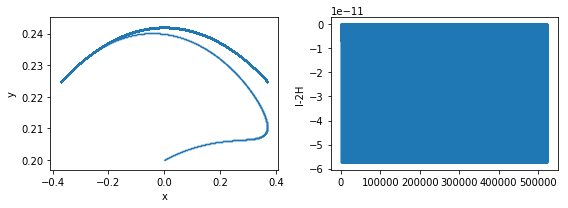

In [20]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(data[0,:],data[2,:],s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.plot(data[5,:]-2*data[4,:])
plt.ylabel('I-2H')
plt.tight_layout()